In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import powerlaw
import sys


In [10]:
#!pip install --target=/D:/tijn2 pysal
#from pysal.explore import esda
#from pysal.lib import weights

In [11]:

# Constants
grid_size = 100
states = {'V': 0, 'H': 1, 'I': 2, 'C': 3}  # V: vacant, H: housing, I: industrial, C: commercial
 
num_iterations = 30  # Number of iterations

# Initialize the grid and counts

counts = {0: grid_size * grid_size, 1: 0, 2: 0, 3: 0}

def initial_land_use(seed_number, grid_size, plot=True):
    np.random.seed(seed_number)
    
    grid = np.zeros((grid_size, grid_size), dtype=int)

    # Define initial conditions
    center_x, center_y = grid_size // 2, grid_size // 2
    
    # Randomly select positions for commercial cells
    commercial_cells = []
    num_commercial = 3
    min_dist_commercial = 1  # Minimum distance from center
    
    while len(commercial_cells) < num_commercial:
        x = np.random.randint(center_x - min_dist_commercial, center_x + min_dist_commercial + 1)
        y = np.random.randint(center_y - min_dist_commercial, center_y + min_dist_commercial + 1)
        if (x, y) not in commercial_cells:
            commercial_cells.append((x, y))

    residential_cells = []
    num_residential = 25
    min_dist = 3  # Minimum distance from commercial cells

    industrial_cells = []
    num_industrial = 4
    min_dist_industrial = 3  # Minimum distance from commercial cells

    # Generate random residential cells around the commercial area
    while len(residential_cells) < num_residential:
        x = np.random.randint(center_x - min_dist, center_x + min_dist + 1)
        y = np.random.randint(center_y - min_dist, center_y + min_dist + 1)
        if (x, y) not in commercial_cells:
            residential_cells.append((x, y))

    # Generate random industrial cells around the commercial area
    while len(industrial_cells) < num_industrial:
        x = np.random.randint(center_x - min_dist_industrial, center_x + min_dist_industrial + 1)
        y = np.random.randint(center_y - min_dist_industrial, center_y + min_dist_industrial + 1)
        if (x, y) not in commercial_cells:
            industrial_cells.append((x, y))

    # Assign initial land use types
    for x, y in commercial_cells:
        grid[x, y] = states['C']  # Commercial
    for x, y in residential_cells:
        grid[x, y] = states['H']  # Residential
    for x, y in industrial_cells:
        grid[x, y] = states['I']  # Industrial

    if plot:
        # Set the figure size
        plt.figure(figsize=(7, 7))
        cmap = plt.cm.colors.ListedColormap(['white', 'skyblue', 'grey', 'orange'])
        plt.imshow(grid, cmap=cmap, origin='lower', vmin=0, vmax=3)
        plt.colorbar(ticks=[0, 1, 2, 3], label='Land Use')
        plt.title('Initial Land Use')
        plt.show()

    return grid



In [12]:
weights_table = {
    'Vacant_Commerce': {
        'C': [25, 25, 25, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        'I': [0]*18,
        'H': [4, 3.5, 3, 2.5, 2, 2, 2, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1],
        'V': [0]*18
    },
    'Vacant_Industry': {
        'C': [0]*18,
        'I': [3, 3, 2, 1, 0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        'H': [-1, -1, 0] + [0]*15,
        'V': [0]*18
    },
    'Vacant_Housing': {
        'C': [-2, -1, 2, 1, 1, 1, 0.5, 0.5, 0.4, 0.3, 0.2, 0.1, 0.1, 0.1, 0, 0, 0, 0],
        'I': [-10, -10, -5, -3, -1] + [0]*13,
        'H': [2, 2, 1.5, 1.5, 1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 0.1, 0.1],
        'V': [0]*18
    },
    'Industry_Commerce': {
        'C': [25, 25, 25, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
        'I': [-2, -2, -2] + [0]*15,
        'H': [4, 3.5, 3, 2.5, 2, 2, 2, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1],
        'V': [0]*18
    },
    'Industry_Industry': {
        'C': [0]*18,
        'I': [0]*18,
        'H': [0]*18,
        'V': [0]*18
    },
    'Industry_Housing': {
        'C': [0]*18,
        'I': [0]*18,
        'H': [0]*18,
        'V': [0]*18
    },
    'Housing_Commerce': {
        'C': [25, 25, 25, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
        'I': [-10, -10, -5, -3, -1] + [0]*13,
        'H': [4, 3.5, 3, 2.5, 2, 2, 2, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1],
        'V': [0]*18
    },
    'Housing_Industry': {
        'C': [0]*18,
        'I': [3, 3, 2, 1, 0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        'H': [-1, -1, 0] + [0]*15,
        'V': [0]*18
    },
    'Housing_Housing': {
        'C': [0]*18,
        'I': [0]*18,
        'H': [0]*18,
        'V': [0]*18
    },
}

# Test of accessing a weight:
transition = 'Vacant_Commerce'
cell_type = 'H'
distance_zone = 1
# This is distance zone is from 0 to 17
weight = weights_table[transition][cell_type][distance_zone]
print(f"The weight for transition={transition}, cell_type={cell_type}, distance_zone={distance_zone} is {weight}")


The weight for transition=Vacant_Commerce, cell_type=H, distance_zone=1 is 3.5


In [13]:

def get_distance_zone(distance):
    zone_mapping = {0: 1, 1: 1.4, 2: 2, 3: 2.2, 4: 2.8, 5: 3, 6: 3.2, 7: 3.6, 8: 4, 9: 4.1, 10: 4.2, 11: 4.5, 12: 5, 13: 5.1, 14: 5.4, 15: 5.7, 16: 5.8, 17: 6}
    for zone, max_distance in reversed(list(zone_mapping.items())):
        if distance >= max_distance:
            return zone
    return 0  # Return 0 if distance is less than the minimum specified distance

def get_neighbourhood(grid, row, col, radius):
    rows, cols = grid.shape
    square_row_range = range(max(0, row - radius), min(rows, row + radius + 1))
    square_col_range = range(max(0, col - radius), min(cols, col + radius + 1))
    square_neighbourhood = grid[np.ix_(square_row_range, square_col_range)]
    circle_mask = np.zeros_like(square_neighbourhood, dtype=bool)
    distance_zones = np.zeros_like(square_neighbourhood, dtype=int)
    # Adjusted center coordinates inside the neighbourhood
    center = min(row, radius), min(col, radius)
    for i in range(square_neighbourhood.shape[0]):
        for j in range(square_neighbourhood.shape[1]):
            distance = np.sqrt((center[0] - i) ** 2 + (center[1] - j) ** 2)
            if distance <= radius:
                circle_mask[i, j] = True
                distance_zones[i, j] = get_distance_zone(distance)
    circle_mask[center] = False  # Exclude the center cell
    return square_neighbourhood[circle_mask], distance_zones[circle_mask]


def cell_type_to_states(state):
    if state == 'Vacant':
        return 0
    elif state == 'Housing':
        return 1
    elif state == 'Industry':
        return 2
    elif state == 'Commerce':
        return 3

def states_to_cell_type(state):
    if state == 0:
        return 'V'
    elif state == 1:
        return 'H'
    elif state == 2:
        return 'I'
    elif state == 3:
        return 'C'


def calculate_transition_potentials(grid, alpha, weights_table, radius):
    transition_potentials = np.zeros((grid.shape[0], grid.shape[1], 4))  # 4 possible states
    transitions = ['Vacant_Commerce', 'Vacant_Industry', 'Vacant_Housing', 'Industry_Commerce', 'Industry_Industry',
                   'Industry_Housing', 'Housing_Commerce', 'Housing_Industry', 'Housing_Housing']
    
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            neighbourhood, distance_zones = get_neighbourhood(grid, i, j, radius)
            for transition in transitions:
                # Extract the current state and desired state from the transition string
                current_state, desired_state = transition.split('_')
                
                current_state_num = cell_type_to_states(current_state)
                desired_state_num = cell_type_to_states(desired_state)
                
            
                if grid[i, j] == current_state_num:
                    sum_weights = 0
                    for neighbor_state, distance_zone in zip(neighbourhood, distance_zones):
                        
                        neighbor_type = states_to_cell_type(neighbor_state)
                        
                        m_kd = weights_table[transition][neighbor_type][distance_zone]

                        if neighbor_state == desired_state_num:
                            sum_weights += m_kd

                    
                    R = np.random.uniform(0, 1)
                    S = 1 + (-math.log(R))**alpha
                    transition_potentials[i, j, desired_state_num] = S * (1 + sum_weights)
    return transition_potentials

In [14]:
test_grid = np.array([
    [3, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 2, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0],
])


alpha = 1

transition_potentials_test = calculate_transition_potentials(test_grid, alpha, weights_table, 2)
print("Transition Potentials:")
print(transition_potentials_test)




Transition Potentials:
[[[ 0.          0.          0.          0.        ]
  [ 0.          6.65934082  1.30032197 68.48462587]
  [ 0.         11.50724477  5.06545111 28.01540142]
  [ 0.          7.11076386  1.77535095  1.90420066]
  [ 0.          4.1383159   2.66950762  2.33986774]]

 [[ 0.          7.0255622   7.81501935 99.2177416 ]
  [ 0.          4.64577695  8.52185782 93.64484363]
  [ 0.          1.46646227  8.59308694  1.6223694 ]
  [ 0.          1.78894695 11.94020374  1.05766268]
  [ 0.          9.27711949  1.27523111  2.7165633 ]]

 [[ 0.         36.49945867  3.39569613 47.24275412]
  [ 0.          1.48169477  5.27154332  1.36764729]
  [ 0.          1.83021558  1.12249358  2.16908488]
  [ 0.          3.20530437  6.45769837  1.82034823]
  [ 0.         17.6681501   4.50044653  2.43935391]]

 [[ 0.          8.04585287  1.78530515  2.48743513]
  [ 0.          1.35024987  5.06952108  4.62857491]
  [ 0.          2.15791921  9.20111645  1.36812721]
  [ 0.          1.21790182  5.80875

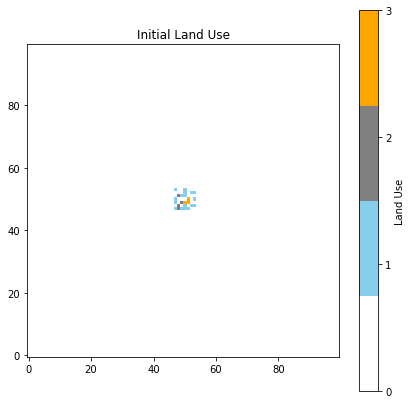

Initial counts: {0: 9976, 1: 17, 2: 4, 3: 3}
Running iteration 1...
Counts at iteration 1: {0: 9871, 1: 85, 2: 39, 3: 5}
Running iteration 2...
Counts at iteration 2: {0: 9767, 1: 152, 2: 74, 3: 7}
Running iteration 3...
Counts at iteration 3: {0: 9661, 1: 221, 2: 109, 3: 9}
Running iteration 4...
Counts at iteration 4: {0: 9558, 1: 288, 2: 143, 3: 11}
Running iteration 5...
Counts at iteration 5: {0: 9458, 1: 351, 2: 178, 3: 13}
Running iteration 6...
Counts at iteration 6: {0: 9353, 1: 419, 2: 213, 3: 15}
Running iteration 7...
Counts at iteration 7: {0: 9253, 1: 484, 2: 246, 3: 17}
Running iteration 8...
Counts at iteration 8: {0: 9148, 1: 553, 2: 280, 3: 19}
Running iteration 9...
Counts at iteration 9: {0: 9045, 1: 619, 2: 315, 3: 21}
Running iteration 10...
Counts at iteration 10: {0: 8943, 1: 684, 2: 350, 3: 23}
Running iteration 11...
Counts at iteration 11: {0: 8842, 1: 749, 2: 384, 3: 25}
Running iteration 12...
Counts at iteration 12: {0: 8740, 1: 815, 2: 418, 3: 27}
Running

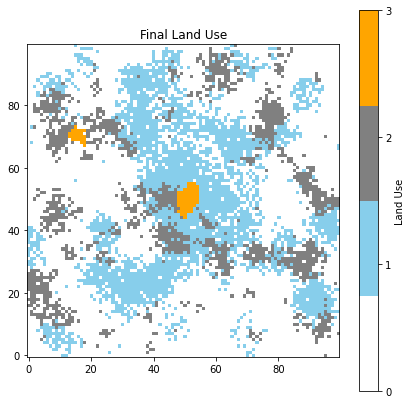

In [36]:
def run_simulation(grid, weights_table, alpha, growth_rates, radius, seed, num_iterations):
    np.random.seed(seed)
    grid_size = grid.shape[0]
    

    counts = {0: 0, 1: 0, 2: 0, 3: 0}
    for i in range(grid_size):
        for j in range(grid_size):
            counts[grid[i, j]] += 1

    print(f"Initial counts: {counts}")

    for iteration in range(num_iterations):
        print(f"Running iteration {iteration+1}...")
        transition_potentials = calculate_transition_potentials(grid, alpha, weights_table, radius)

        highest_potentials = {}
        for i in range(grid_size):
            for j in range(grid_size):
                if grid[i, j] == states['V']:
                    potential_states = ['H', 'I', 'C']
                elif grid[i, j] == states['H']:
                    potential_states = ['I', 'C']
                elif grid[i, j] == states['I']:
                    potential_states = ['C']
                else:
                    potential_states = []
                    
                if potential_states:
                    highest_potentials[(i, j)] = max(potential_states, key=lambda state: transition_potentials[i, j, states[state]])

        for new_state_key in sorted(states, key=lambda k: states[k], reverse=True):
            new_state = states[new_state_key]
            if new_state_key != 'V':
                num_to_convert = int(grid_size * grid_size * growth_rates[new_state_key])
                potential_cells = [(i, j) for i, j in highest_potentials.keys() if highest_potentials[(i, j)] == new_state_key]
                potential_cells.sort(key=lambda cell: transition_potentials[cell[0], cell[1], states[highest_potentials[cell]]], reverse=True)
                
                for cell in potential_cells[:num_to_convert]:
                    counts[grid[cell]] -= 1
                    counts[new_state] += 1
                    grid[cell] = new_state

        print(f"Counts at iteration {iteration+1}: {counts}")

    plt.figure(figsize=(7, 7))
    cmap = plt.cm.colors.ListedColormap(['white', 'skyblue', 'grey', 'orange'])
    plt.imshow(grid, cmap=cmap, origin='lower', vmin=0, vmax=3)
    plt.colorbar(ticks=[0, 1, 2, 3], label='Land Use')
    plt.title('Final Land Use')
    plt.show()


growth_rates = {
    'H': 0.007,  
    'I': 0.0035,
    'C': 0.0002,
}


num_iterations = 40
# Run the simulation
grid = initial_land_use(seed_number=0, grid_size=100, plot=True)
run_simulation(grid, weights_table, alpha=2.5, growth_rates=growth_rates, radius = 6, seed=3, num_iterations=num_iterations)


In [ ]:
# make a plot of counts vs iterations


In [14]:
def clustering(m, rtype):
    """ Algorithm for finding clusters and labeling them. 
    INPUT: Matrix m with occupied 1 and unoccupied 0"""
    assert type(rtype) == int
    assert m.shape[0] == m.shape[1]
    
    dim = m.shape[0]
    largest_label = 0;
    label = np.zeros([dim, dim])
    for x in range(dim):
        for y in range(dim):
            above = m[x-1, y]
            left = m[x, y-1]
            # For the boundary conditions, set above and left to zero.
            if x == 0:
                above = 0
            if y == 0:
                left = 0
            # Assign cluster IDs according to neighbours   
            if m[x,y] == rtype:
                if above != rtype and left != rtype: # no neighbors, new cluster id
                    largest_label += 1
                    label[x,y] = largest_label
                elif above == rtype and left != rtype: # cluster extends from above, change id
                    label[x,y] = label[x-1,y]
                elif above != rtype and left == rtype: # cluster extends from left, change id
                    label[x,y] = label[x,y-1]
                elif above == rtype and left == rtype: # both belong to cluster, make a union
                    m, label = cluster_union(m, label, x, y)             
    return label
            
def cluster_union(m, label, x, y):
    """
    Union the two clusters and labels both clusters the same.
    """
    if label[x-1,y] == label[x,y-1]: # If labels are the same, then set x,y as same label
        label[x,y] = label[x-1,y]
        return m, label
    else: # else different clusters so rename one
        new_id, old_id = np.min([label[x-1,y], label[x,y-1]]), np.max([label[x-1,y], label[x,y-1]])
        label[x,y] = new_id # set label of current x,y
        label[label == old_id] = new_id # change all old IDs to the new one
    return m, label

def run_clustering(m):
    """
    Runs the clustering algorithm for each of the cell types, returns a pandas dataframe with the columns cluster size, count, id.
    INPUT: the matrix with the different IDs in the cells. 
    """
    clusters = pd.DataFrame()
    # Run each of the cluster types in a loop
    for i in np.unique(m)[1:]: # not the zeros
        cluster_ids = clustering(m, int(i))
        cluster_size = np.unique(cluster_ids, return_counts=True) # count size of clusters in matrix of cell types
        size, count = np.unique(cluster_size[1][1:], return_counts=True) # select only the cells that contain something (first element is empty)
        # f
        clusters = pd.concat([clusters, pd.DataFrame([size, count, i * np.ones(len(count))]).T], axis = 0)
        
    clusters.columns = ['Cluster_size','Cluster_count','cell_type']
    return clusters


def test_powerlaw():
    """
    Function to statistically test the power law relationships
    Jeff Alstott, Ed Bullmore, Dietmar Plenz. (2014). powerlaw: a Python package for analysis of heavy-tailed distributions. PLoS ONE 9(1): e85777
    """
    fit = powerlaw.Fit(empirical_data) # Fits the data to a power law parameter
    # Then test if it is more likely to be a powerlaw or exponential or lognormal.
    test1 = fit.distribution_compare('power_law', 'exponential')
    test2 = fit.distribution_compare('power_law', 'lognormal')
    return [fit, test1, test2]


    Cluster_size  Cluster_count  cell_type
0            1.0          205.0        1.0
1            2.0           37.0        1.0
2            3.0           17.0        1.0
3            4.0            7.0        1.0
4            5.0            9.0        1.0
5            6.0            2.0        1.0
6            7.0            3.0        1.0
7            8.0            1.0        1.0
8           10.0            1.0        1.0
9           13.0            1.0        1.0
10          14.0            1.0        1.0
11          22.0            1.0        1.0
12          28.0            1.0        1.0
13          34.0            1.0        1.0
14          36.0            1.0        1.0
15          37.0            1.0        1.0
16          48.0            1.0        1.0
17          53.0            1.0        1.0
18          56.0            1.0        1.0
19          67.0            1.0        1.0
20         115.0            1.0        1.0
21        1579.0            1.0        1.0
0          

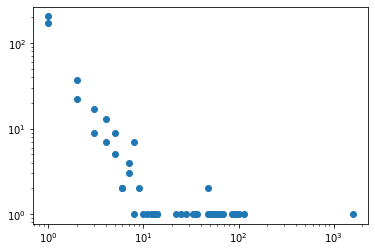

In [15]:
x = run_clustering(grid)
print(x)
# Just testing the log plotting
plt.scatter(x.Cluster_size, x.Cluster_count)
plt.yscale('log'), plt.xscale('log')
plt.show()

In [18]:
res = x[x.cell_type == 1].Cluster_count
ind = x[x.cell_type == 2].Cluster_count
com = x[x.cell_type == 3].Cluster_count
results_res = powerlaw.Fit(res)
results_ind = powerlaw.Fit(ind)
results_com = powerlaw.Fit(com)
#print(res)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


In [19]:
def power_law(x, a, b):
    return a*np.power(x, b)


In [20]:
pars, cov = curve_fit(f=power_law, xdata=x[x.cell_type == 1].Cluster_size, ydata=res, p0=[300, -1.8], bounds=(-np.inf, np.inf))

print(pars)

[204.79375582  -2.38272394]


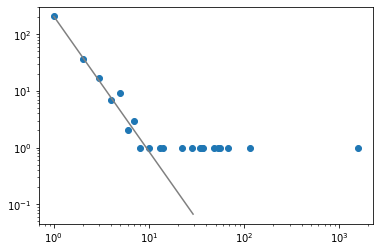

In [21]:
r = np.arange(1,30)
xx = x[x.cell_type == 1]
plt.scatter(xx.Cluster_size, xx.Cluster_count)
plt.plot(r, power_law(r, pars[0], pars[1]), c= 'grey')

plt.yscale('log'), plt.xscale('log')
plt.show()

In [16]:
pip install lempel-ziv-complexity

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: C:\Users\tijn2\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip


In [17]:
from lempel_ziv_complexity import lempel_ziv_complexity
s = '1001111011000010'
lempel_ziv_complexity(s)

8

In [22]:
# def lempel_ziv_complexity_2d(ca_grid):
#     dictionary = {}
#     substring_count = 0

#     encoded_rows = []
#     for row in ca_grid:
#         encoded_rows.append("".join(str(cell) for cell in row))

#     encoded_columns = []
#     for col_idx in range(len(ca_grid[0])):
#         column = [row[col_idx] for row in ca_grid]
#         encoded_columns.append("".join(str(cell) for cell in column))

#     encoded_strings = encoded_rows + encoded_columns

#     for encoded_string in encoded_strings:
#         for i in range(len(encoded_string)):
#             current_substring = encoded_string[:i + 1]

#             if current_substring not in dictionary:
#                 dictionary[current_substring] = True
#                 substring_count += 1

#     return substring_count

# lempel_ziv_complexity_2d(grid)

17784

In [24]:
# def calculate_joint_probability(ca_grid):
#     joint_counts = np.zeros((4, 4))  # 4x4 matrix to store joint counts
#     height, width = ca_grid.shape

#     # Count the occurrences of pairs of states in the CA grid
#     for i in range(height):
#         for j in range(width):
#             if i < height - 1:
#                 x = ca_grid[i, j]
#                 y = ca_grid[i + 1, j]
#                 joint_counts[x, y] += 1
#             if j < width - 1:
#                 x = ca_grid[i, j]
#                 y = ca_grid[i, j + 1]
#                 joint_counts[x, y] += 1

#     # Compute joint probabilities by dividing by the total number of pairs
#     joint_probabilities = joint_counts / (height * width)
#     return joint_probabilities

# def calculate_conditional_probability(joint_probabilities):
#     marginal_probabilities = np.sum(joint_probabilities, axis=1)
#     conditional_probabilities = joint_probabilities / marginal_probabilities[:, np.newaxis]
#     return conditional_probabilities

# def calculate_conditional_entropy(conditional_probabilities):
#     conditional_entropy = -np.sum(conditional_probabilities * np.log2(conditional_probabilities))
#     return conditional_entropy


# joint_probs = calculate_joint_probability(grid)
# conditional_probs = calculate_conditional_probability(joint_probs)
# conditional_entropy = calculate_conditional_entropy(conditional_probs)

# print("Conditional Entropy:", conditional_entropy)


Conditional Entropy: 4.565872226445261


In [32]:
from collections import Counter

def conditional_entropy(grid):
    counter = Counter()
    total_count = 0

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            state = grid[i, j]
            counter[state] += 1
            total_count += 1

    conditional_entropy = 0
    for state, count in counter.items():
        probability = count / total_count
        conditional_entropy -= probability * np.log2(probability)

    return conditional_entropy



Conditional Entropy: 1.397376712107437


In [41]:
entropy = conditional_entropy(grid)
print(entropy)

grid1 = np.random.randint(0, 4, size=(100, 100))
entropy1 = conditional_entropy(grid1)
print("Conditional Entropy:", entropy1)

grid2 = np.random.randint(0, 1, size=(100, 100))
entropy2 = conditional_entropy(grid2)
print("Conditional Entropy:", entropy2)

1.397376712107437
Conditional Entropy: 1.9999313821448854
Conditional Entropy: 0.0


Running simulation with seed 39309...


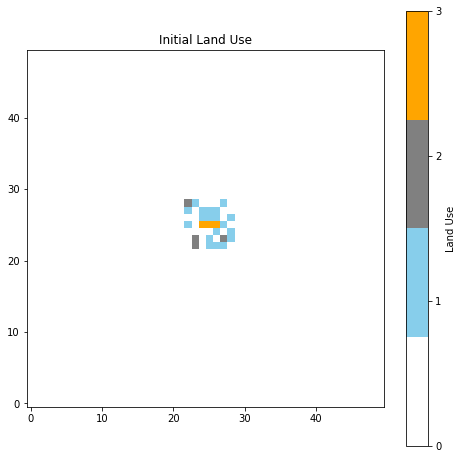

Running iteration 1...
Running iteration 2...
Running iteration 3...
Running iteration 4...
Running iteration 5...
Running iteration 6...
Running iteration 7...
Running iteration 8...
Running iteration 9...
Running iteration 10...
Running iteration 11...
Running iteration 12...
Running iteration 13...
Running iteration 14...
Running iteration 15...
Running iteration 16...
Running iteration 17...
Running iteration 18...
Running iteration 19...
Running iteration 20...
Running iteration 21...
Running iteration 22...
Running iteration 23...
Running iteration 24...
Running iteration 25...
Running iteration 26...
Running iteration 27...
Running iteration 28...
Running iteration 29...
Running iteration 30...
Running iteration 31...
Running iteration 32...
Running iteration 33...
Running iteration 34...
Running iteration 35...
Running iteration 36...
Running iteration 37...
Running iteration 38...
Running iteration 39...
Running iteration 40...
Running iteration 41...
Running iteration 42...
R

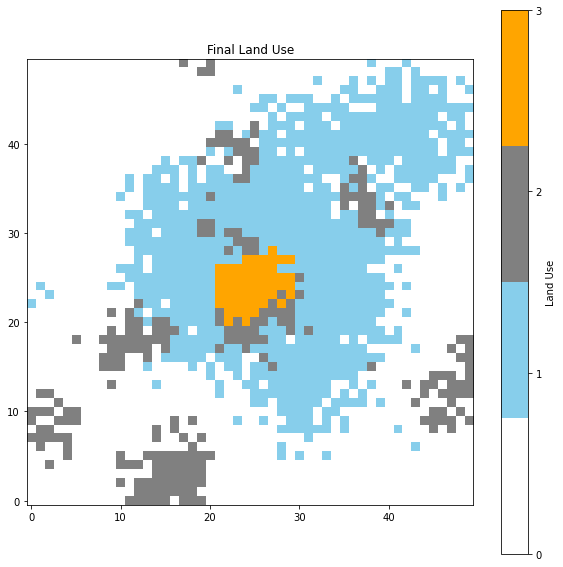

Simulation completed.

Running simulation with seed 24381...


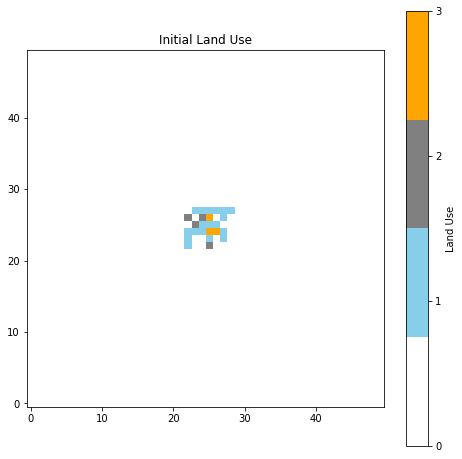

Running iteration 1...
Running iteration 2...
Running iteration 3...
Running iteration 4...
Running iteration 5...
Running iteration 6...
Running iteration 7...
Running iteration 8...
Running iteration 9...
Running iteration 10...
Running iteration 11...
Running iteration 12...
Running iteration 13...
Running iteration 14...
Running iteration 15...
Running iteration 16...
Running iteration 17...
Running iteration 18...
Running iteration 19...
Running iteration 20...
Running iteration 21...
Running iteration 22...
Running iteration 23...
Running iteration 24...
Running iteration 25...
Running iteration 26...
Running iteration 27...
Running iteration 28...
Running iteration 29...
Running iteration 30...
Running iteration 31...
Running iteration 32...
Running iteration 33...
Running iteration 34...
Running iteration 35...
Running iteration 36...
Running iteration 37...
Running iteration 38...
Running iteration 39...
Running iteration 40...
Running iteration 41...
Running iteration 42...
R

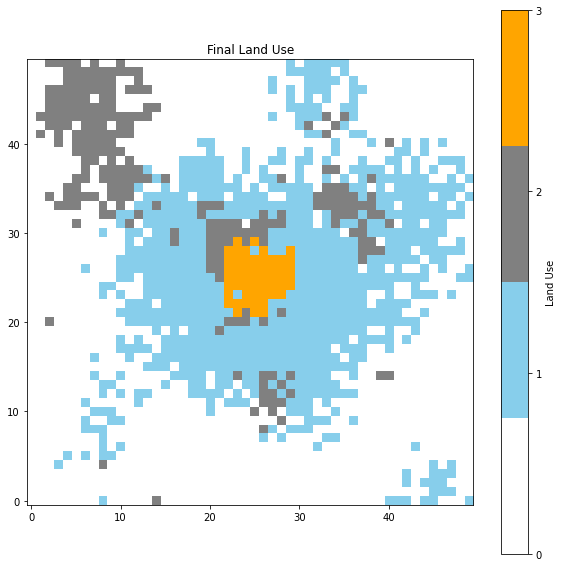

Simulation completed.

Running simulation with seed 12973...


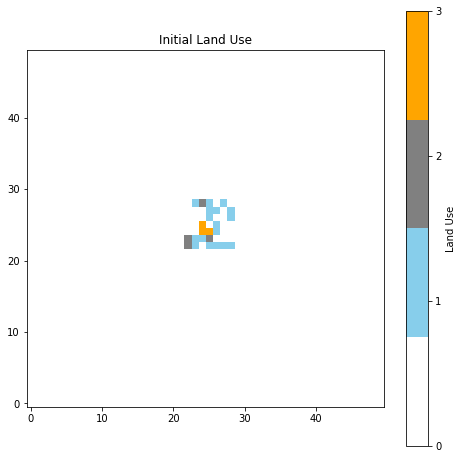

Running iteration 1...
Running iteration 2...
Running iteration 3...
Running iteration 4...
Running iteration 5...
Running iteration 6...
Running iteration 7...
Running iteration 8...
Running iteration 9...
Running iteration 10...
Running iteration 11...
Running iteration 12...
Running iteration 13...
Running iteration 14...
Running iteration 15...
Running iteration 16...
Running iteration 17...
Running iteration 18...
Running iteration 19...
Running iteration 20...
Running iteration 21...
Running iteration 22...
Running iteration 23...
Running iteration 24...
Running iteration 25...
Running iteration 26...
Running iteration 27...
Running iteration 28...
Running iteration 29...
Running iteration 30...
Running iteration 31...
Running iteration 32...
Running iteration 33...
Running iteration 34...
Running iteration 35...
Running iteration 36...
Running iteration 37...
Running iteration 38...
Running iteration 39...
Running iteration 40...
Running iteration 41...
Running iteration 42...
R

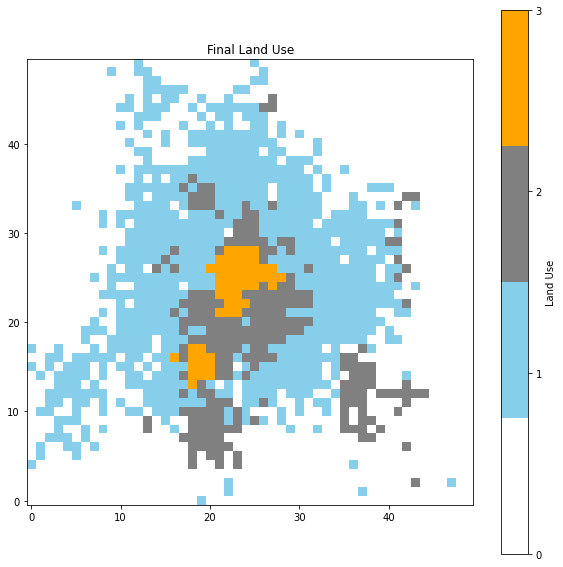

Simulation completed.

Running simulation with seed 10430...


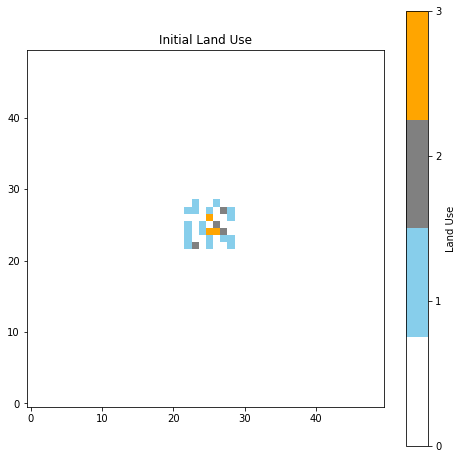

Running iteration 1...
Running iteration 2...
Running iteration 3...
Running iteration 4...
Running iteration 5...
Running iteration 6...
Running iteration 7...
Running iteration 8...
Running iteration 9...
Running iteration 10...
Running iteration 11...
Running iteration 12...
Running iteration 13...
Running iteration 14...
Running iteration 15...
Running iteration 16...
Running iteration 17...
Running iteration 18...
Running iteration 19...
Running iteration 20...
Running iteration 21...
Running iteration 22...
Running iteration 23...
Running iteration 24...
Running iteration 25...
Running iteration 26...
Running iteration 27...
Running iteration 28...
Running iteration 29...
Running iteration 30...
Running iteration 31...
Running iteration 32...
Running iteration 33...
Running iteration 34...
Running iteration 35...
Running iteration 36...
Running iteration 37...
Running iteration 38...
Running iteration 39...
Running iteration 40...
Running iteration 41...
Running iteration 42...
R

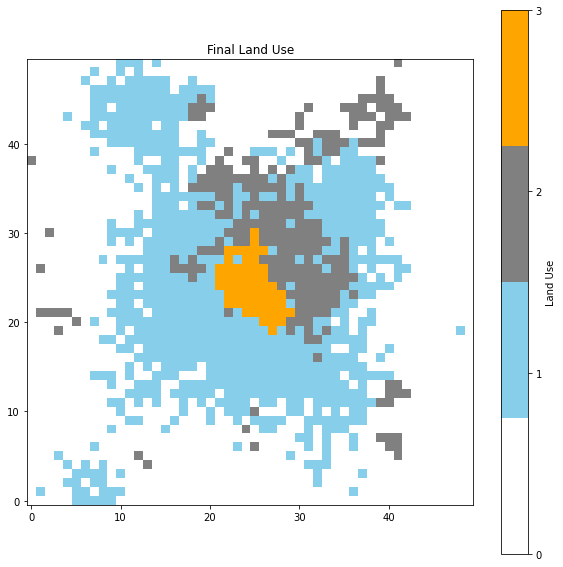

Simulation completed.

Running simulation with seed 40712...


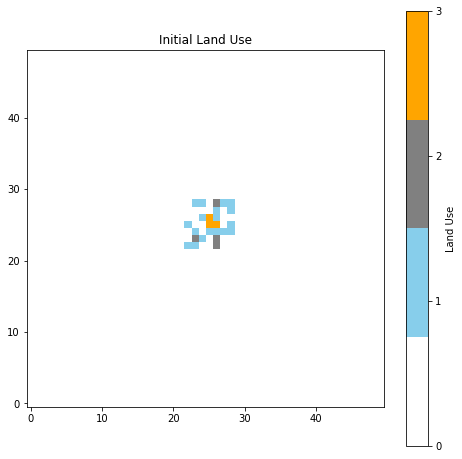

Running iteration 1...
Running iteration 2...
Running iteration 3...
Running iteration 4...
Running iteration 5...
Running iteration 6...
Running iteration 7...
Running iteration 8...
Running iteration 9...
Running iteration 10...
Running iteration 11...
Running iteration 12...
Running iteration 13...
Running iteration 14...
Running iteration 15...
Running iteration 16...
Running iteration 17...
Running iteration 18...
Running iteration 19...
Running iteration 20...
Running iteration 21...
Running iteration 22...
Running iteration 23...
Running iteration 24...
Running iteration 25...
Running iteration 26...
Running iteration 27...
Running iteration 28...
Running iteration 29...
Running iteration 30...
Running iteration 31...
Running iteration 32...
Running iteration 33...
Running iteration 34...
Running iteration 35...
Running iteration 36...
Running iteration 37...
Running iteration 38...
Running iteration 39...
Running iteration 40...
Running iteration 41...
Running iteration 42...
R

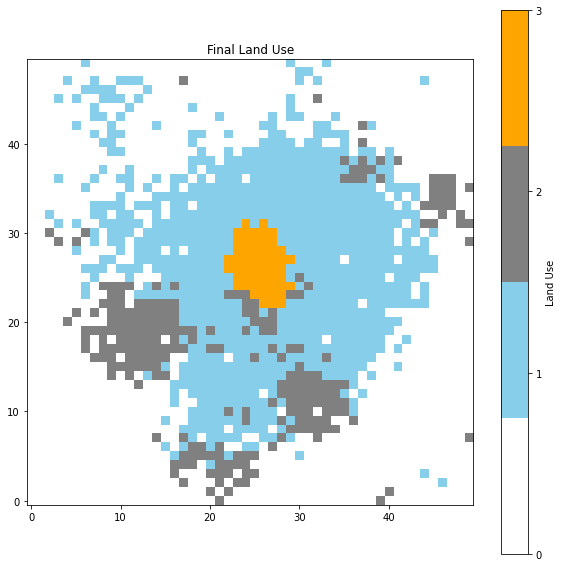

Simulation completed.

Running simulation with seed 10151...


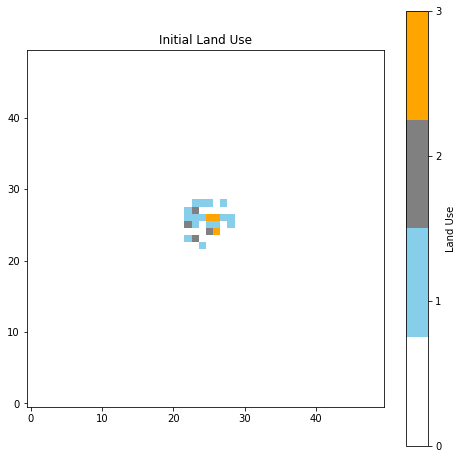

Running iteration 1...
Running iteration 2...
Running iteration 3...
Running iteration 4...
Running iteration 5...
Running iteration 6...
Running iteration 7...
Running iteration 8...
Running iteration 9...
Running iteration 10...
Running iteration 11...
Running iteration 12...
Running iteration 13...
Running iteration 14...
Running iteration 15...
Running iteration 16...
Running iteration 17...
Running iteration 18...
Running iteration 19...
Running iteration 20...
Running iteration 21...
Running iteration 22...
Running iteration 23...
Running iteration 24...
Running iteration 25...
Running iteration 26...
Running iteration 27...
Running iteration 28...
Running iteration 29...
Running iteration 30...
Running iteration 31...
Running iteration 32...
Running iteration 33...
Running iteration 34...
Running iteration 35...
Running iteration 36...
Running iteration 37...
Running iteration 38...
Running iteration 39...
Running iteration 40...
Running iteration 41...
Running iteration 42...
R

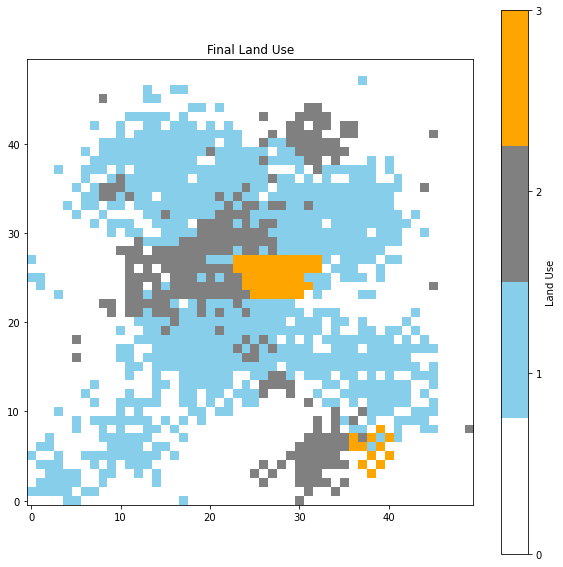

Simulation completed.

Running simulation with seed 48186...


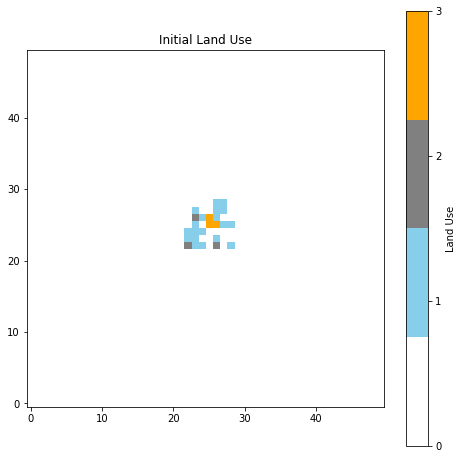

Running iteration 1...
Running iteration 2...
Running iteration 3...
Running iteration 4...
Running iteration 5...
Running iteration 6...
Running iteration 7...
Running iteration 8...
Running iteration 9...
Running iteration 10...
Running iteration 11...
Running iteration 12...
Running iteration 13...
Running iteration 14...
Running iteration 15...
Running iteration 16...
Running iteration 17...
Running iteration 18...
Running iteration 19...
Running iteration 20...
Running iteration 21...
Running iteration 22...
Running iteration 23...
Running iteration 24...
Running iteration 25...
Running iteration 26...
Running iteration 27...
Running iteration 28...
Running iteration 29...
Running iteration 30...
Running iteration 31...
Running iteration 32...
Running iteration 33...
Running iteration 34...
Running iteration 35...
Running iteration 36...
Running iteration 37...
Running iteration 38...
Running iteration 39...
Running iteration 40...
Running iteration 41...
Running iteration 42...
R

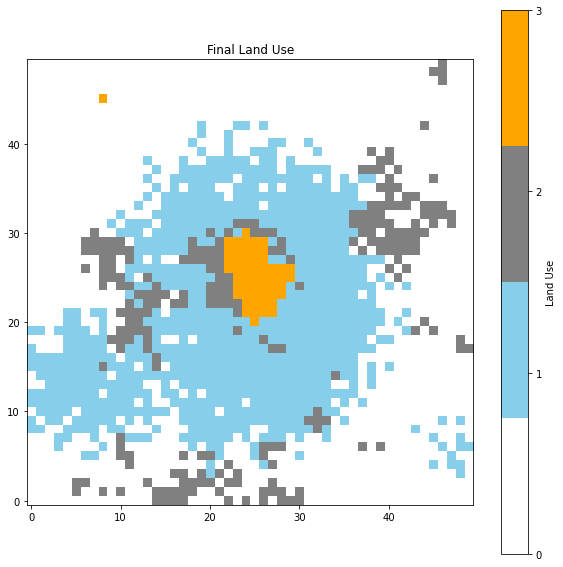

Simulation completed.

Running simulation with seed 22592...


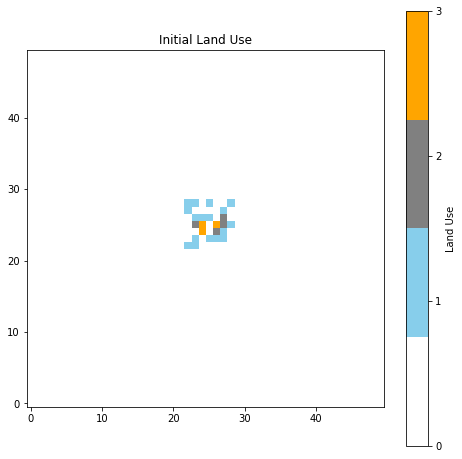

Running iteration 1...
Running iteration 2...
Running iteration 3...
Running iteration 4...
Running iteration 5...
Running iteration 6...
Running iteration 7...
Running iteration 8...
Running iteration 9...
Running iteration 10...
Running iteration 11...
Running iteration 12...
Running iteration 13...
Running iteration 14...
Running iteration 15...
Running iteration 16...
Running iteration 17...
Running iteration 18...
Running iteration 19...
Running iteration 20...
Running iteration 21...
Running iteration 22...
Running iteration 23...
Running iteration 24...
Running iteration 25...
Running iteration 26...
Running iteration 27...
Running iteration 28...
Running iteration 29...
Running iteration 30...
Running iteration 31...
Running iteration 32...
Running iteration 33...
Running iteration 34...
Running iteration 35...
Running iteration 36...
Running iteration 37...
Running iteration 38...
Running iteration 39...
Running iteration 40...
Running iteration 41...
Running iteration 42...
R

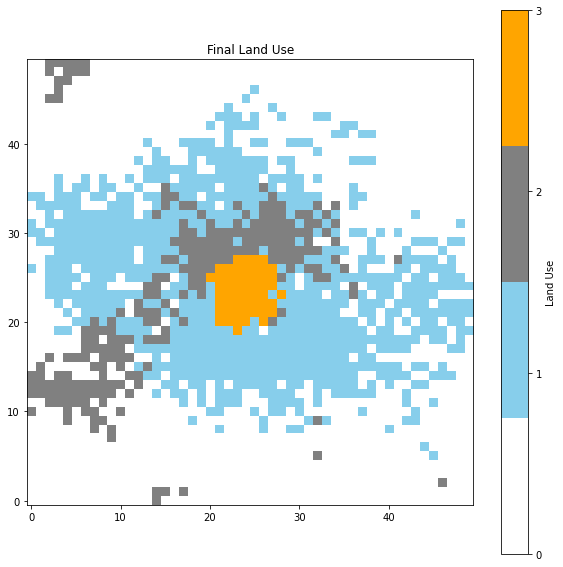

Simulation completed.

Running simulation with seed 27099...


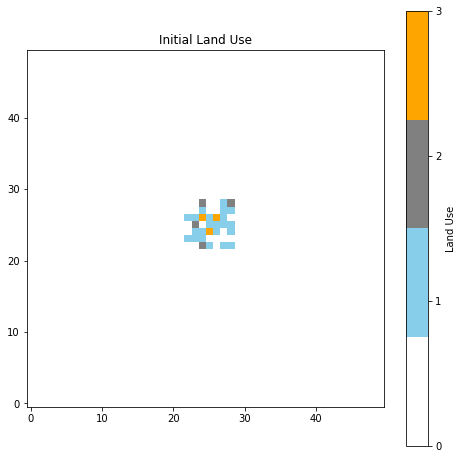

Running iteration 1...
Running iteration 2...
Running iteration 3...
Running iteration 4...
Running iteration 5...
Running iteration 6...
Running iteration 7...
Running iteration 8...
Running iteration 9...
Running iteration 10...
Running iteration 11...
Running iteration 12...
Running iteration 13...
Running iteration 14...
Running iteration 15...
Running iteration 16...
Running iteration 17...
Running iteration 18...
Running iteration 19...
Running iteration 20...
Running iteration 21...
Running iteration 22...
Running iteration 23...
Running iteration 24...
Running iteration 25...
Running iteration 26...
Running iteration 27...
Running iteration 28...
Running iteration 29...
Running iteration 30...
Running iteration 31...
Running iteration 32...
Running iteration 33...
Running iteration 34...
Running iteration 35...
Running iteration 36...
Running iteration 37...
Running iteration 38...
Running iteration 39...
Running iteration 40...
Running iteration 41...
Running iteration 42...
R

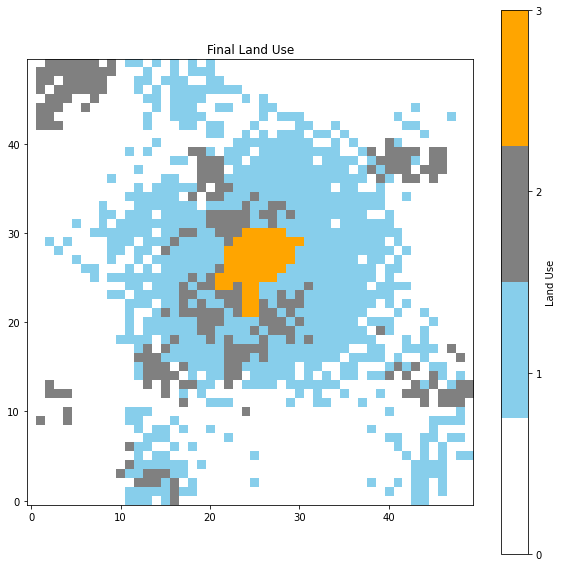

Simulation completed.

Running simulation with seed 55714...


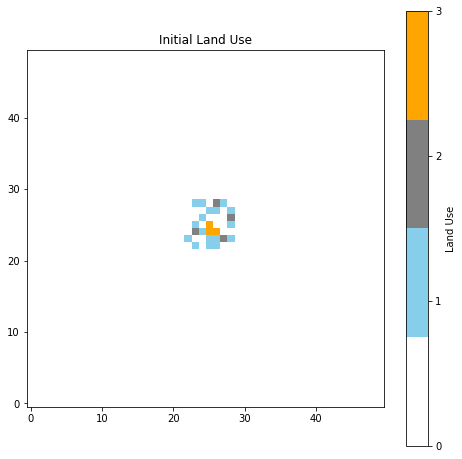

Running iteration 1...
Running iteration 2...
Running iteration 3...
Running iteration 4...
Running iteration 5...
Running iteration 6...
Running iteration 7...
Running iteration 8...
Running iteration 9...
Running iteration 10...
Running iteration 11...
Running iteration 12...
Running iteration 13...
Running iteration 14...
Running iteration 15...
Running iteration 16...
Running iteration 17...
Running iteration 18...
Running iteration 19...
Running iteration 20...
Running iteration 21...
Running iteration 22...
Running iteration 23...
Running iteration 24...
Running iteration 25...
Running iteration 26...
Running iteration 27...
Running iteration 28...
Running iteration 29...
Running iteration 30...
Running iteration 31...
Running iteration 32...
Running iteration 33...
Running iteration 34...
Running iteration 35...
Running iteration 36...
Running iteration 37...
Running iteration 38...
Running iteration 39...
Running iteration 40...
Running iteration 41...
Running iteration 42...
R

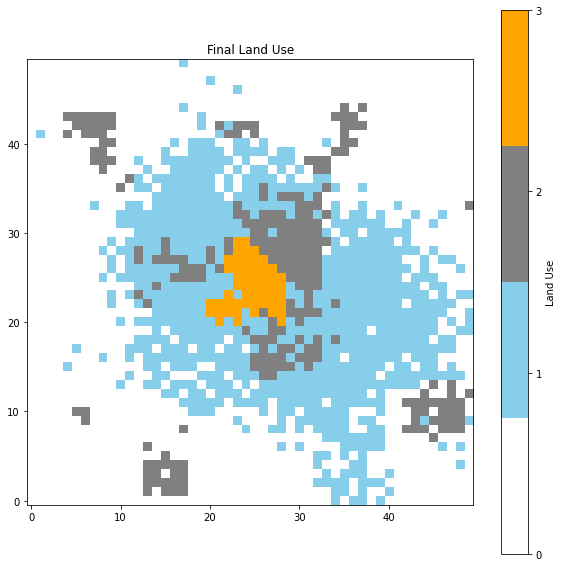

Simulation completed.



In [20]:
def run_simulation_multiple(grid, weights_table, alpha, growth_rates, radius, seed, num_iterations):
    np.random.seed(seed)
    
    grid_size = grid.shape[0]



    for iteration in range(num_iterations):
        print(f"Running iteration {iteration+1}...")
        transition_potentials = calculate_transition_potentials(grid, alpha, weights_table, radius)

        highest_potentials = {}
        for i in range(grid_size):
            for j in range(grid_size):
                if grid[i, j] == states['V']:
                    potential_states = ['H', 'I', 'C']
                elif grid[i, j] == states['H']:
                    potential_states = ['I', 'C']
                elif grid[i, j] == states['I']:
                    potential_states = ['C']
                else:
                    potential_states = []
                    
                if potential_states:
                    highest_potentials[(i, j)] = max(potential_states, key=lambda state: transition_potentials[i, j, states[state]])

        for new_state_key in sorted(states, key=lambda k: states[k], reverse=True):
            new_state = states[new_state_key]
            if new_state_key != 'V':
                num_to_convert = int(grid_size * grid_size * growth_rates[new_state_key])
                potential_cells = [(i, j) for i, j in highest_potentials.keys() if highest_potentials[(i, j)] == new_state_key]
                potential_cells.sort(key=lambda cell: transition_potentials[cell[0], cell[1], states[highest_potentials[cell]]], reverse=True)
                
                for cell in potential_cells[:num_to_convert]:
                    
                    grid[cell] = new_state

        

    plt.figure(figsize=(10, 10))
    cmap = plt.cm.colors.ListedColormap(['white', 'skyblue', 'grey', 'orange'])
    plt.imshow(grid, cmap=cmap, origin='lower', vmin=0, vmax=3)
    plt.colorbar(ticks=[0, 1, 2, 3], label='Land Use')
    plt.title('Final Land Use')
    plt.show()

# make seed to be 10 random integers from 0 to 100000
seeds = np.random.randint(0, 100000, 10)

growth_rates = {
    'H': 0.007,  
    'I': 0.002,
    'C': 0.0005,
}
num_iterations = 50

for seed in seeds:
    print(f"Running simulation with seed {seed}...")
    new_grid = initial_land_use(seed_number=seed, grid_size=grid_size, plot=True)
    run_simulation_multiple(new_grid, weights_table, alpha=2.5, growth_rates=growth_rates, radius=6, seed=seed, num_iterations=num_iterations)
    print("Simulation completed.\n")

